In [1]:
from music21 import *

### 首先创建 简谱-规则
因为手里的谱子是简谱，因此需要创建一个从简谱到音名的一一对应规则
- 长音：1-
- 下加线：<1>
- 延长半音：1.
- 小节线：|
- 低音：(1)
- 高音：[1]
- 升音：#1
- 降音：b1

在此基础上定义“音符类”，用来将数字简谱中的每个音所对应的时值、音高、升降等信息记录下来：

In [2]:
PitchClass = ['C','D','E','F','G','A','B']
TypeClass = ['64th','32nd','16th','eighth','quarter','half','whole']   
class StrNote:
    '''
     对音符的字符串信息进行保存
     分别存储pitch，octave ,accidental，并最终拼接起来
    '''
    def __init__(self):
        '''
            默认简谱中的do是C5
            因此是pitch下标为0
            中音的八度octave是第五个
            没有升降号accidental 
            默认是四分之一音符4
            默认没有附点
        '''
        self.pitch = 0
        self.octave = 5
        self.accidental = ''
        self.type = 4
        self.dot = 0
        
    def __init__(self,pitch):
        '''
          有参构造
        '''
        self.pitch = pitch-1
        self.octave = 5
        self.accidental = ''
        self.type = 4
        self.dot = 0
            
    def __add__(self, y):
        '音调pitch加一位'
        self.pitch = (self.pitch+y)%7
        return self
        
    def __sub__(self,y):
        '音调pitch减一位'
        self.pitch = (self.pitch+7-y)%7
        return self
    
    def setflat(self):
        '降音'
        self.accidental = 'b'
    
    def setsharp(self):
        '升音'
        self.accidental = '#'
    
    def setnormal(self):
        '变成普通音'
        self.accidental = ''
        
    def higher(self):
        '提高一个八度'
        self.octave += 1 
        
    def lower(self):
        '降低一个八度'
        self.octave -= 1 
    
    def longer(self):
        '时间加长'
        if self.type == 5 and self.dot == 0:
            self.dot = 1
        else:
            self.type += 1
            
    def shotter(self):
        '时间减短'
        self.type -= 1
    
    def adddot(self):
        '添加附点'
        self.dot += 1
        
    def getstr(self):
        '返回这个音的字符串'
        return str(PitchClass[self.pitch]) + str(self.octave) + str(self.accidental)
        
    
    def getnote(self):
        if self.pitch == -1:
            stopnote = note.Rest(1)
            stopnote.duration.type = TypeClass[self.type]
            stopnote.duration.dots = self.dot
            return stopnote
        '返回音符对象'
        thisnote = note.Note(str(PitchClass[self.pitch]) + str(self.octave) + str(self.accidental))
        thisnote.duration.type = TypeClass[self.type]
        thisnote.duration.dots = self.dot
        return thisnote
 
'判断是数字还是符号'
def isnum(input):
    try:
        int(input)
        return True
    except:
        return False

定义字符串->乐谱的函数，用来将字符串转换成乐谱

In [3]:
notelist = []
def str2stream(music_str):

    s = stream.Score(id='mainScore')
    '''
    lowerflag  -  低音标志()
    higherflag -  高音标志[]
    shotterflag - 短时标志<>
    longgerflag - 长时标志--
    
    '''
    lowerflag = False
    higherflag = False
    sharpflag = False
    shotterflag = 0
    measurenum = 1
    for each in music_str:
        if isnum(each):
            midnote = StrNote(int(each))
            if lowerflag == True:
                midnote.lower()
            if higherflag == True:
                midnote.higher()
            if shotterflag != 0:
                for i in range(shotterflag):
                    midnote.shotter()
            if sharpflag == True:
                midnote.setsharp()
                #print(midnote)
                sharpflag = False
            notelist.append(midnote)
        else:
            if each == '(':
                lowerflag = True
            elif each == ')':
                lowerflag = False
            elif each == '[':
                higherflag = True 
            elif each == ']':
                higherflag = False 
            elif each == '<':
                shotterflag += 1 
            elif each == '>':
                shotterflag -= 1
            elif each == '.':
                notelist[len(notelist)-1].adddot()
            elif each == '-':
                notelist[len(notelist)-1].longer()
            elif each == '#':
                sharpflag = True
                #notelist[len(notelist)-1].setsharp()
            elif each == 'b':
                notelist[len(notelist)-1].setflat()
            elif each == '|':
                midstream = stream.Measure(number=measurenum)
                measurenum+=1
                for eachnote in notelist:
                    midstream.append(eachnote.getnote())
                s.append(midstream)
                notelist.clear()
            else:
                continue
    
    if len(notelist)!= 0:
        midstream = stream.Measure(number=measurenum)
        for eachnote in notelist:
            midstream.append(eachnote.getnote())
        s.append(midstream)
        notelist.clear()
    play(s)
    return s

在return s之前有一个魔法函数play(将会在下面定义)，他的作用是阻止一个bug的发生，就像下面这样：

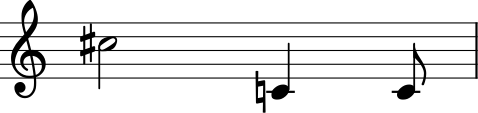

In [4]:
s = stream.Score(id='mainScore')
m = stream.Measure(number=1)
m.append(note.Note('C5#', type="half"))
m.append(note.Note('C', type="quarter"))
m.append(note.Note('C', type="eighth"))
s.append(m)
s.show()
s.show('midi')

可以听出来，刚才这段音频只播放了后面两个音，而用了魔法函数就能解决这个问题(我也不知道为什么)

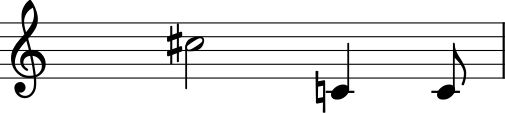

In [5]:
def play(x):
    """Returns nothing. Outputs a midi realization of x, a note or stream.
    Primarily for use in notebooks and web environments.
    """
    if isinstance(x, stream.Stream):
        # x = copy.deepcopy(x)
        for subStream in x.recurse(streamsOnly=True, includeSelf=True):
            mss = subStream.getElementsByClass(stream.Measure)
            for ms in mss:
                ms.offset += 1.0
    if isinstance(x, note.Note):
        s = stream.Stream()
        s.append(note.Rest(1))
        s.append(x)
        x = s
    x.show()
    x.show('midi')
play(s)

可以听出来，现在音已经全了。
### 根据规则写简谱
接下来我们要根据规则写简谱，规则如果忘了的话可以再看一遍
- 长音：1-
- 下加线：<1>
- 延长半音：1.
- 小节线：|
- 低音：(1)
- 高音：[1]
- 升音：#1
- 降音：b1
除了<>这个符号是我自己加的以外，剩下的规则都和现在大家用的数字谱一样

首先我们生成一段两个小节的音频：

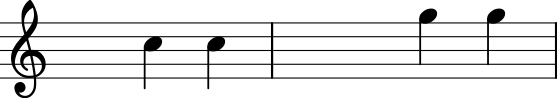

<music21.stream.Score mainScore>

In [6]:
s = '11|55'
str2stream(s)

如果在55后面加了一个|可能会更加的标准，表示最后一个小节的结束，不过没什么所谓，因为加不加都可以

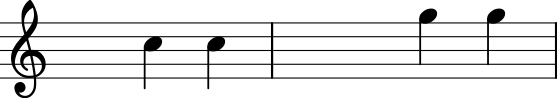

<music21.stream.Score mainScore>

In [7]:
s = '11|55|'
str2stream(s)

接下来是延长音、下划线(我不知道叫啥)以及附点

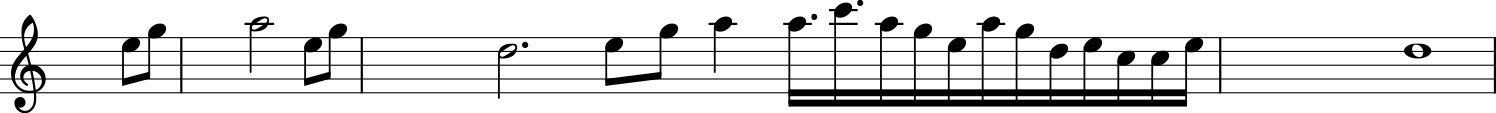

<music21.stream.Score mainScore>

In [8]:
s = '<35>|6-<35>|2--<35>6<<6.[1].6536523113>>|2---'
str2stream(s)

可以看到延长音从-、--、--都是可以的。下划线的<>可以进行嵌套.附点的话会将前一个音的时间拉长一半。比如原来2响1秒钟，2.就是响1.5秒钟；2响0.75秒，2.就是1.075秒(0.75+0.375)。以此类推

接下来是升降

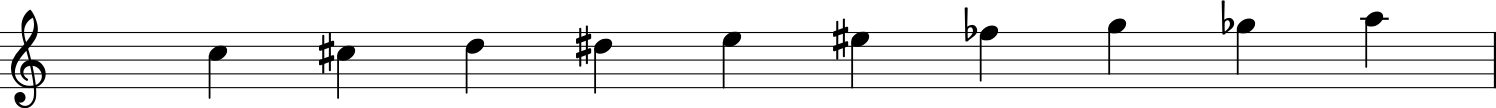

<music21.stream.Score mainScore>

In [9]:
s = '1 #1 2 #2 3 #3 4 b5 5 b6'
str2stream(s)

其实这里不用空格，不过为了保持美观整洁，就把音符都空格开了

最后是高音低音，就在音的外面套个括号就行了

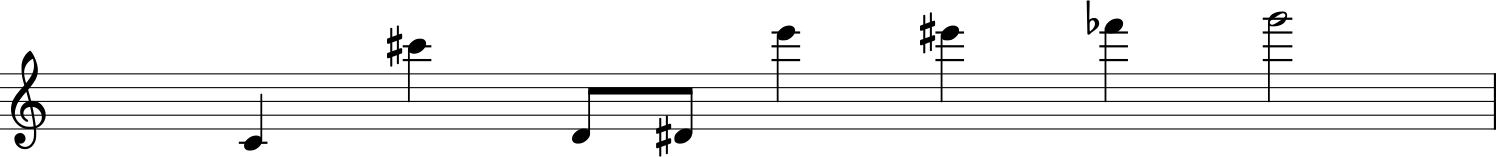

<music21.stream.Score mainScore>

In [10]:
s = '(1) [#1] <(2 #2)> [3 #3 4 b5-] '
str2stream(s)

接下来是我已经写好了的几个谱子

In [11]:
# 小星星
star = '11|55|66|5-|44|33|22|1-|55|44|33|2-|55|44|33|2-|11|55|66|5-|44|33|22|1-'

# 多年以后
manyyears = '1<12>|3<34>|5<65>|3-|5<43>|2-|'
manyyears += '4<32>|1-|1<12>|3<34>|5<65>|3-|'
manyyears += '5<43>|2<32>|1-|1-|5<43>|2<(55)>|'
manyyears += '4<32>|1-|5<43>|2<(55)>|4<32>|1-|'
manyyears += '1<12>|3<34>|5<65>|3-|5<43>|2<32>|1-|1-'

# 灵儿响叮当
bring = '<33>3|<33>3|<351.<2>>|3-|<44>4|<43>3|<3223>|'
bring += '25|<33>3|<33>3|<351.<2>>|3-|<44>4|<43>3|'
bring += '<5542>|1-|<(5)321>|(5)-|<(5)321>|(6)-|<(6)432>|'
bring += '(7)-|<5542>|3-|<(5)321>|(5)-|<(5)321>|(6)-|'
bring += '<(6)432>|<55>5|<6542>|1-|<33>3|<33>3|<351.<2>>|'
bring += '3-|<44>4|<43>3|<3223>|25|<33>3|<33>3|'
bring += '<351.<2>>|3-|<44>4|<43>3|<5542>|1[1]'

# 你和蔷薇一样美丽啊啊啊啊啊啊啊
aaaa = '<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#13.>|<3#4#1<(76)>> |<0> |<<(67)>#13> |<3#4#1<(76)>>0'
aaaa += '(<#4<0>67>)|<<1.(7.>6#4)>|#1.<2<#1>>(7)'

aaaa +='<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#1.<0>>|<<#1.(76)>>#4.|<#1(766<#4>)>|#1.<(7)>'
aaaa +='<<(67)>#13.>|<3#4#1<(76)>> |<0> |<<(67)>#13> |<3#4#1<(7>6)>'
aaaa +='<(6)<#13>#4.<0>3.#4#1(7. <0> 6<#467>6-)>'

aaaa +='<#1(<7>6-#5<3>#5-673)3<2#>>1'
aaaa +='<(6)#13#4-> | <3<#4#1>(7. 6<#467>6-)>'
aaaa +='<(3)2#1(7<6>6)| <(3)2#1>(7<6>6.) | <(3)2#1>(7<6>6.) | <(3)2#1>(7<6>7.)>'
aaaa +='<<(67)>#1#1|#3#1(<7>6-)| (6)#43#4|3#1(7>6)'
aaaa +='<(6)<6#46>>|6---'


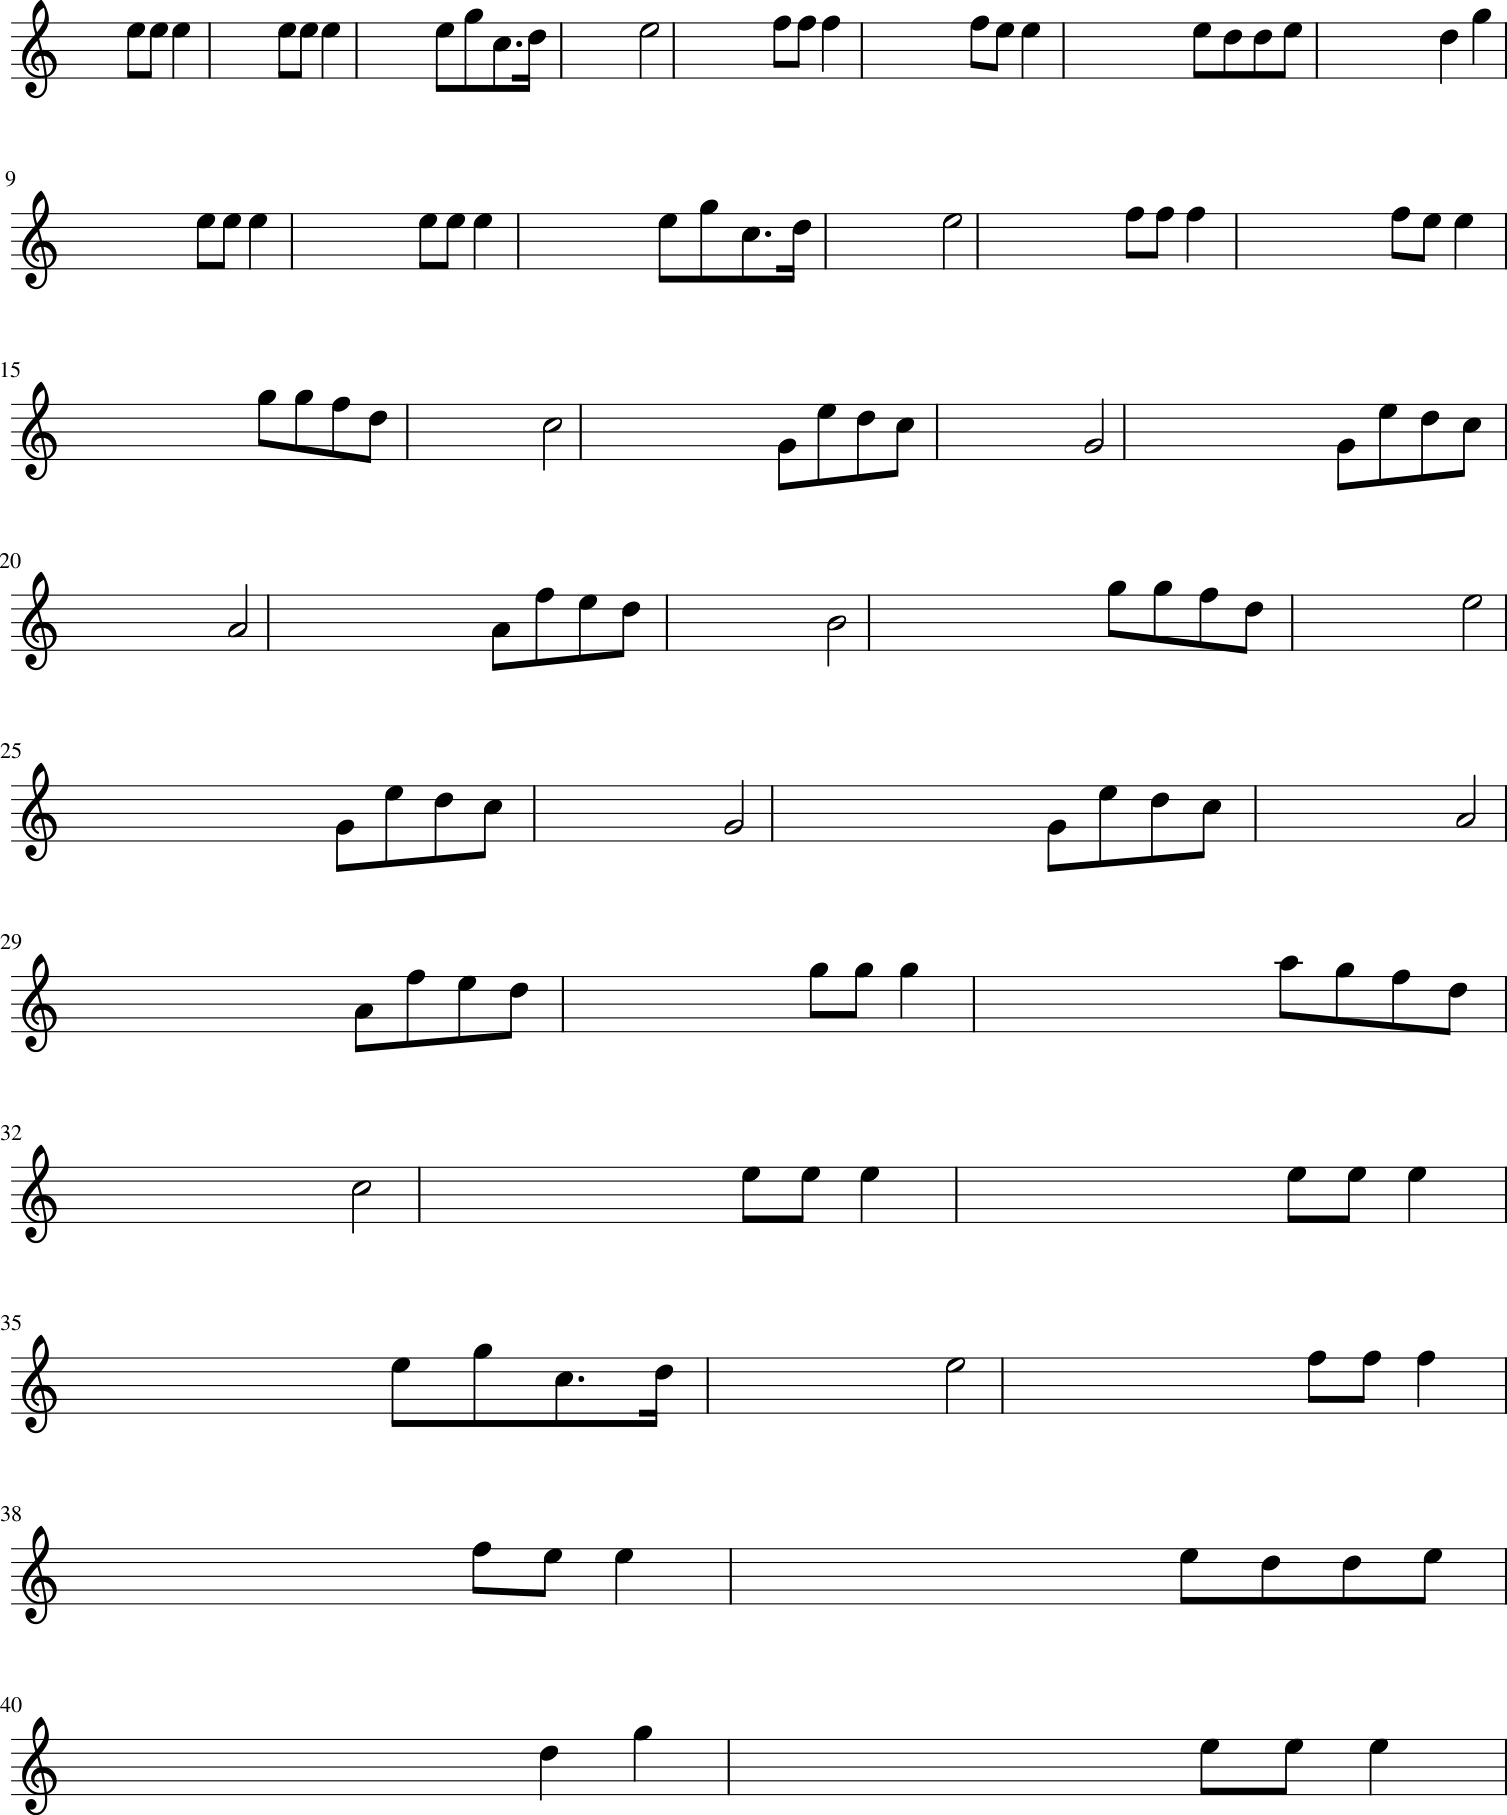

NameError: name 'mf' is not defined

In [12]:
s = str2stream(bring)


In [13]:
mf = midi.translate.streamToMidiFile(s)
mf.open('./star.mid', 'wb')
mf.write()
mf.close()

In [ ]:
print(b)

In [ ]:
s.write('midi', fp=r'.\小星星.mid')

In [ ]:
import os
def writemusic(s,path):
    s.write('midi', fp=path)
    print("ffmpeg -i "+ path + " " + path[:-4] + ".wav")
    os.system("ffmpeg -i "+ path + " " + path[:-4] + ".wav" )
    
path = r'.\star.mid' 
writemusic(s,path)

In [ ]:
import wave

In [ ]:
path = r'.\star.mid' 
wv = wave.open(path, 'r')

In [ ]:
from midi2audio import FluidSynth

In [ ]:
fs = FluidSynth()

In [ ]:
fs.midi_to_audio(path, 'output.wav')